In [1]:
import os
from pathlib import Path

testfolder = 'Simulations/1axis'

if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in Simulations/1axis


In [2]:
import bifacial_radiance as br
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)
print("pyplot ", plt.matplotlib.__version__)

Working on a  Darwin 21.6.0
Python version  3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
Pandas version  2.0.3
bifacial_radiance version  0.4.2+179.g317ccac.dirty
pyplot  3.7.2


In [4]:
simulationname = '1axis-groundscan'

# Location
lat = 39.7555
lon = -105.2211

# Scene Parameters
azimuth_ang=90 # Facing south
tilt=30

# MakeModule Parameters
moduletype='PVmod'
numpanels=1
module_x = 2 # m
module_y = 1 # m. slope we will measure
sensorsy=2
sensorsground=5

# SceneDict Parameters
pitch = 5.7 # m
albedo = 0.2
clearance_height = 0.5 # m  
nMods = 4 
nRows = 3

sceneDict = {'tilt':10,'pitch':5.7,'clearance_height':0.2,'azimuth':180, 'nMods': 20, 'nRows': 7} 

In [5]:
demo = br.RadianceObj(simulationname,path = testfolder)
demo.setGround(albedo)
epwfile = demo.getEPW(lat, lon)

path = Simulations/1axis
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_CO_Golden-NREL.724666_TMY3.epw
 ... OK!


In [6]:
module=demo.makeModule(name=moduletype,x=module_x,y=module_y)


Module Name: PVmod
Module PVmod updated in module.json
Pre-existing .rad file objects/PVmod.rad will be overwritten



In [7]:
metdata = demo.readWeatherFile(epwfile, coerce_year=2021, starttime='2021-06-01', endtime='2021-06-30_23')

8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs/metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos


In [8]:
hub_height = 1.5
pitch = 5.7
sazm = 90
fixed_tilt_angle = None
gcr = 2 / pitch
cumulativesky = True

trakerParams = {
    'limit_angle': 50,
    'angledelta': 30,
    'backtrack': True,
    'gcr': gcr,
    'cumulativesky': cumulativesky,
    'azimuth': sazm,
    'fixed_tilt_angle': fixed_tilt_angle
}

In [9]:
trackerdict = demo.set1axis(**trakerParams)

Saving file EPWs/1axis_-60.0.csv, # points: 60
Saving file EPWs/1axis_-30.0.csv, # points: 60
Saving file EPWs/1axis_-0.0.csv, # points: 250
Saving file EPWs/1axis_30.0.csv, # points: 80


In [10]:
if cumulativesky:
    demo.genCumSky1axis()
else:
    demo.gendaylit1axis()

message: There were 60 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-60.0.rad
message: There were 60 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-30.0.rad
message: There were 249 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-0.0.rad
message: There were 80 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_30.0.rad


In [11]:
sceneDict = {
    'pitch': pitch,
    'hub_height': hub_height,
    'nMods': 5,
    'nRows': 2
}

In [12]:
trakerdict = demo.makeScene1axis(module=moduletype, sceneDict=sceneDict)
trakerdict = demo.makeOct1axis()


Making .rad files for cumulativesky 1-axis workflow
4 Radfiles created in /objects/

Making 4 octfiles in root directory.
Created 1axis_-60.0.oct
Created 1axis_-30.0.oct
Created 1axis_-0.0.oct
Created 1axis_30.0.oct


In [13]:
sensorsgroundvalues = np.array([3, 5, 10, 20, 30, 100, 150, 200, 250, 300, 400, 500])
angles = np.array([-0.0, -30.0, -60.0, 30.0])

In [14]:
resultsdict = {}

for i, sensorsground in enumerate(sensorsgroundvalues):
    print("Doing sensor", i)
    print(f"sensorsground: {sensorsground}")
    trakerdict = demo.analysis1axisground(customname='1-axis_groundscan_' + str(sensorsground), 
                                          sensorsground=sensorsground)
    angleswm2dict = {}

    for i, angle in enumerate(angles):
        wm2 = []
        for i, y in enumerate(trakerdict[angle]['Results'][0]['AnalysisObj'].y):
             if y >= 1 and y <= pitch - 1:
                wm2.append(trakerdict[angle]['Results'][0]['AnalysisObj'].Wm2Front[i])
        resultsdict[(sensorsground)] = np.mean(wm2)

Doing sensor 0
sensorsground: 3
Linescan in process: 1axis_-60.01-axis_groundscan_3_Front
Saved: results/irr_1axis_-60.01-axis_groundscan_3.csv
Index: -60.0. Wm2Ground: 3571.2376666666664. Sensorsground: 3
Linescan in process: 1axis_-30.01-axis_groundscan_3_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_3.csv
Index: -30.0. Wm2Ground: 10710.345333333333. Sensorsground: 3
Linescan in process: 1axis_-0.01-axis_groundscan_3_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_3.csv
Index: -0.0. Wm2Ground: 83427.29999999999. Sensorsground: 3
Linescan in process: 1axis_30.01-axis_groundscan_3_Front
Saved: results/irr_1axis_30.01-axis_groundscan_3.csv
Index: 30.0. Wm2Ground: 48341.54666666666. Sensorsground: 3
Doing sensor 1
sensorsground: 5
Linescan in process: 1axis_-60.01-axis_groundscan_5_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_5.csv
Index: -60.0. Wm2Ground: 3379.4055999999996. Sensorsground: 5
Linescan in process: 1axis_-30.01-axis_groundscan_5_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_5.csv
Index: -30.0. Wm2Ground: 11078.0474. Sensorsground: 5
Linescan in process: 1axis_-0.01-axis_groundscan_5_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_5.csv
Index: -0.0. Wm2Ground: 94628.12599999999. Sensorsground: 5
Linescan in process: 1axis_30.01-axis_groundscan_5_Front
Saved: results/irr_1axis_30.01-axis_groundscan_5.csv
Index: 30.0. Wm2Ground: 50303.646. Sensorsground: 5
Doing sensor 2
sensorsground: 10
Linescan in process: 1axis_-60.01-axis_groundscan_10_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_10.csv
Index: -60.0. Wm2Ground: 3632.8441999999995. Sensorsground: 10
Linescan in process: 1axis_-30.01-axis_groundscan_10_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_10.csv
Index: -30.0. Wm2Ground: 11010.2519. Sensorsground: 10
Linescan in process: 1axis_-0.01-axis_groundscan_10_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_10.csv
Index: -0.0. Wm2Ground: 100717.89. Sensorsground: 10
Linescan in process: 1axis_30.01-axis_groundscan_10_Front
Saved: results/irr_1axis_30.01-axis_groundscan_10.csv
Index: 30.0. Wm2Ground: 47792.256. Sensorsground: 10
Doing sensor 3
sensorsground: 20
Linescan in process: 1axis_-60.01-axis_groundscan_20_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_20.csv
Index: -60.0. Wm2Ground: 3692.7961999999998. Sensorsground: 20
Linescan in process: 1axis_-30.01-axis_groundscan_20_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_20.csv
Index: -30.0. Wm2Ground: 10965.1392. Sensorsground: 20
Linescan in process: 1axis_-0.01-axis_groundscan_20_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_20.csv
Index: -0.0. Wm2Ground: 102286.61750000001. Sensorsground: 20
Linescan in process: 1axis_30.01-axis_groundscan_20_Front
Saved: results/irr_1axis_30.01-axis_groundscan_20.csv
Index: 30.0. Wm2Ground: 47230.336. Sensorsground: 20
Doing sensor 4
sensorsground: 30
Linescan in process: 1axis_-60.01-axis_groundscan_30_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_30.csv
Index: -60.0. Wm2Ground: 3557.6534333333334. Sensorsground: 30
Linescan in process: 1axis_-30.01-axis_groundscan_30_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_30.csv
Index: -30.0. Wm2Ground: 11226.529966666665. Sensorsground: 30
Linescan in process: 1axis_-0.01-axis_groundscan_30_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_30.csv
Index: -0.0. Wm2Ground: 102777.365. Sensorsground: 30
Linescan in process: 1axis_30.01-axis_groundscan_30_Front
Saved: results/irr_1axis_30.01-axis_groundscan_30.csv
Index: 30.0. Wm2Ground: 46963.70733333333. Sensorsground: 30
Doing sensor 5
sensorsground: 100
Linescan in process: 1axis_-60.01-axis_groundscan_100_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_100.csv
Index: -60.0. Wm2Ground: 3454.3020500000007. Sensorsground: 100
Linescan in process: 1axis_-30.01-axis_groundscan_100_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_100.csv
Index: -30.0. Wm2Ground: 11203.624270000002. Sensorsground: 100
Linescan in process: 1axis_-0.01-axis_groundscan_100_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_100.csv
Index: -0.0. Wm2Ground: 104281.38140000003. Sensorsground: 100
Linescan in process: 1axis_30.01-axis_groundscan_100_Front
Saved: results/irr_1axis_30.01-axis_groundscan_100.csv
Index: 30.0. Wm2Ground: 46771.387599999995. Sensorsground: 100
Doing sensor 6
sensorsground: 150
Linescan in process: 1axis_-60.01-axis_groundscan_150_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_150.csv
Index: -60.0. Wm2Ground: 3648.252793333333. Sensorsground: 150
Linescan in process: 1axis_-30.01-axis_groundscan_150_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_150.csv
Index: -30.0. Wm2Ground: 11102.861993333334. Sensorsground: 150
Linescan in process: 1axis_-0.01-axis_groundscan_150_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_150.csv
Index: -0.0. Wm2Ground: 104311.63433333335. Sensorsground: 150
Linescan in process: 1axis_30.01-axis_groundscan_150_Front
Saved: results/irr_1axis_30.01-axis_groundscan_150.csv
Index: 30.0. Wm2Ground: 47160.92593333333. Sensorsground: 150
Doing sensor 7
sensorsground: 200
Linescan in process: 1axis_-60.01-axis_groundscan_200_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_200.csv
Index: -60.0. Wm2Ground: 3574.36407. Sensorsground: 200
Linescan in process: 1axis_-30.01-axis_groundscan_200_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_200.csv
Index: -30.0. Wm2Ground: 11132.548295. Sensorsground: 200
Linescan in process: 1axis_-0.01-axis_groundscan_200_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_200.csv
Index: -0.0. Wm2Ground: 103780.00265000001. Sensorsground: 200
Linescan in process: 1axis_30.01-axis_groundscan_200_Front
Saved: results/irr_1axis_30.01-axis_groundscan_200.csv
Index: 30.0. Wm2Ground: 47055.81415. Sensorsground: 200
Doing sensor 8
sensorsground: 250
Linescan in process: 1axis_-60.01-axis_groundscan_250_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_250.csv
Index: -60.0. Wm2Ground: 3670.5760880000003. Sensorsground: 250
Linescan in process: 1axis_-30.01-axis_groundscan_250_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_250.csv
Index: -30.0. Wm2Ground: 10852.983059999999. Sensorsground: 250
Linescan in process: 1axis_-0.01-axis_groundscan_250_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_250.csv
Index: -0.0. Wm2Ground: 104027.8042. Sensorsground: 250
Linescan in process: 1axis_30.01-axis_groundscan_250_Front
Saved: results/irr_1axis_30.01-axis_groundscan_250.csv
Index: 30.0. Wm2Ground: 47299.347519999996. Sensorsground: 250
Doing sensor 9
sensorsground: 300
Linescan in process: 1axis_-60.01-axis_groundscan_300_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_300.csv
Index: -60.0. Wm2Ground: 3656.0592300000003. Sensorsground: 300
Linescan in process: 1axis_-30.01-axis_groundscan_300_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_300.csv
Index: -30.0. Wm2Ground: 11285.117093333334. Sensorsground: 300
Linescan in process: 1axis_-0.01-axis_groundscan_300_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_300.csv
Index: -0.0. Wm2Ground: 104140.76433333335. Sensorsground: 300
Linescan in process: 1axis_30.01-axis_groundscan_300_Front
Saved: results/irr_1axis_30.01-axis_groundscan_300.csv
Index: 30.0. Wm2Ground: 47564.19243333334. Sensorsground: 300
Doing sensor 10
sensorsground: 400
Linescan in process: 1axis_-60.01-axis_groundscan_400_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_400.csv
Index: -60.0. Wm2Ground: 3475.0437075. Sensorsground: 400
Linescan in process: 1axis_-30.01-axis_groundscan_400_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_400.csv
Index: -30.0. Wm2Ground: 11028.073105000001. Sensorsground: 400
Linescan in process: 1axis_-0.01-axis_groundscan_400_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_400.csv
Index: -0.0. Wm2Ground: 104487.1165. Sensorsground: 400
Linescan in process: 1axis_30.01-axis_groundscan_400_Front
Saved: results/irr_1axis_30.01-axis_groundscan_400.csv
Index: 30.0. Wm2Ground: 47266.371775. Sensorsground: 400
Doing sensor 11
sensorsground: 500
Linescan in process: 1axis_-60.01-axis_groundscan_500_Front


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved: results/irr_1axis_-60.01-axis_groundscan_500.csv
Index: -60.0. Wm2Ground: 3508.1125899999997. Sensorsground: 500
Linescan in process: 1axis_-30.01-axis_groundscan_500_Front
Saved: results/irr_1axis_-30.01-axis_groundscan_500.csv
Index: -30.0. Wm2Ground: 11348.764842. Sensorsground: 500
Linescan in process: 1axis_-0.01-axis_groundscan_500_Front
Saved: results/irr_1axis_-0.01-axis_groundscan_500.csv
Index: -0.0. Wm2Ground: 104400.5765. Sensorsground: 500
Linescan in process: 1axis_30.01-axis_groundscan_500_Front
Saved: results/irr_1axis_30.01-axis_groundscan_500.csv
Index: 30.0. Wm2Ground: 47020.980480000006. Sensorsground: 500


/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/storopov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
trakerdict

{-0.0: {'csvfile': 'EPWs/1axis_-0.0.csv',
  'surf_azm': 179.99999716835316,
  'surf_tilt': 0.0,
  'datetime': Index(['2021-06-01 05:00:00', '2021-06-01 08:00:00', '2021-06-01 09:00:00',
         '2021-06-01 10:00:00', '2021-06-01 15:00:00', '2021-06-01 16:00:00',
         '2021-06-01 17:00:00', '2021-06-02 05:00:00', '2021-06-02 08:00:00',
         '2021-06-02 09:00:00',
         ...
         '2021-06-29 16:00:00', '2021-06-29 17:00:00', '2021-06-30 05:00:00',
         '2021-06-30 08:00:00', '2021-06-30 09:00:00', '2021-06-30 10:00:00',
         '2021-06-30 11:00:00', '2021-06-30 15:00:00', '2021-06-30 16:00:00',
         '2021-06-30 17:00:00'],
        dtype='object', length=250),
  'count': 250,
  'skyfile': 'skies/1axis_-0.0.rad',
  'radfile': 'objects/1axis-0.0__C_1.50000_rtr_5.70000_tilt_0.00000_5modsx2rows_origin0,0.rad',
  'scene': {'module': {'x': 2, 'y': 1, 'z': 0.02, 'modulematerial': 'black', 'scenex': 2.01, 'sceney': 1.0, 'scenez': 0.1, 'numpanels': 1, 'bifi': 1, 'text': '!

In [16]:
resultsdict

{3: 55289.27,
 5: 53975.02,
 10: 53499.823333333334,
 20: 53933.37333333333,
 30: 53571.570555555554,
 100: 52998.00640625,
 150: 53170.73604166667,
 200: 52912.983230769234,
 250: 53116.551728395054,
 300: 53833.00541237114,
 400: 53477.78184615384,
 500: 52930.33407407407}

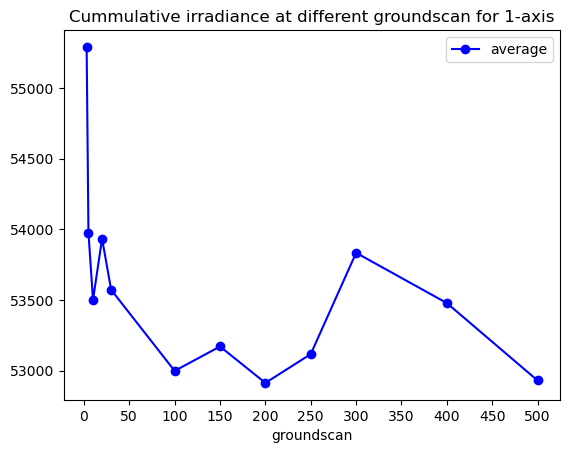

In [17]:
df1 = pd.DataFrame({
    'groundscan': sensorsgroundvalues,
    'average': resultsdict.values()
})

df1.plot(x='groundscan', y='average', marker='o', color='blue')
plt.xticks(np.arange(0, 501, 50))
plt.title('Cummulative irradiance at different groundscan for 1-axis')
plt.show()